# Logistic Regression with Python

For this lecture we will be working with the Titanic Data Set from Kaggle. This is a very famous data set and very often is a student's first step in machine learning!

We'll be trying to predict a classification - survival or deceased. Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

In [1]:
import pandas as pd  # read dataset using in-built functions
import numpy as np  # work with arrays
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns  # Visualisation + Statistical Analysis
%matplotlib inline

## The Data

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA
- Start by checking missing data

## Missing data
We can use seaborn to create a simple heatmap to see where we are missing data. 

In [4]:
train.isnull()
## Wherever there is TRUE, it means there's a null value present there. 
# This can be quite daunting if we've a million records, so an efficient way is to use a heatmap.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

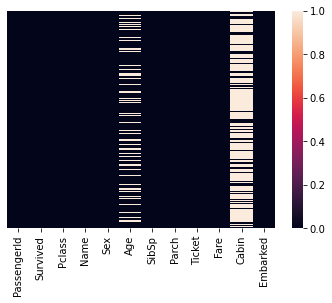

In [5]:
sns.heatmap(train.isnull(),yticklabels=False)
# yticklabels = False is so that we don't see any labels on the y-axis, i.e, records (890)
# null values are highlighted, i.e, white

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<AxesSubplot:xlabel='Survived', ylabel='count'>

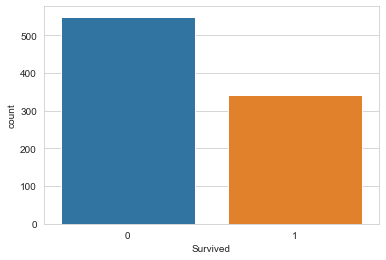

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

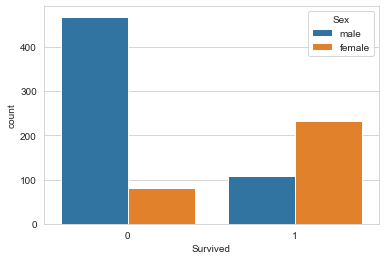

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train)

In [18]:
train.value_counts('Sex')

Sex
male      577
female    314
dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

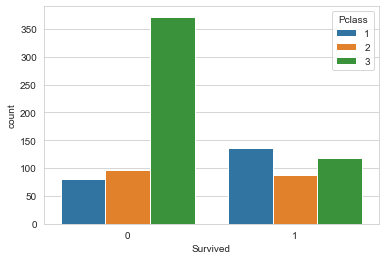

In [19]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train)

/Users/mahakkaurchhabra/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

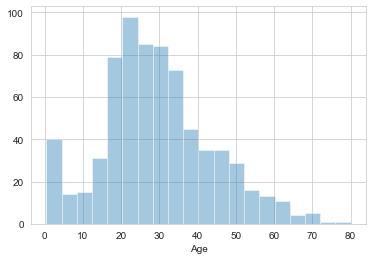

In [20]:
sns.distplot(train['Age'].dropna(),kde=False)

<AxesSubplot:>

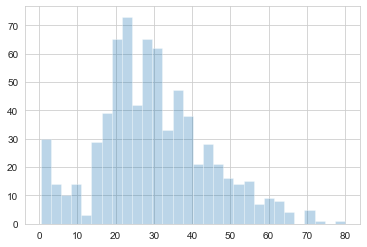

In [23]:
train['Age'].hist(bins=30,alpha=0.3) # in matplotlib

<AxesSubplot:xlabel='SibSp', ylabel='count'>

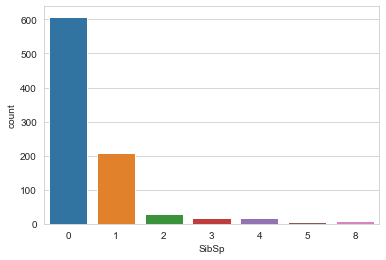

In [25]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

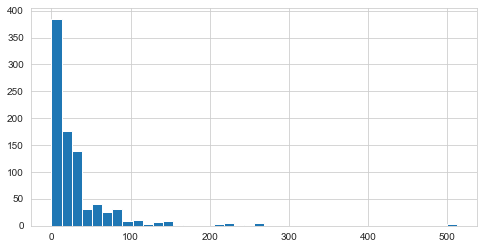

In [28]:
train['Fare'].hist(bins=40,figsize=(8,4))

## Cufflinks for plots

In [29]:
import cufflinks as cf
cf.go_offline()

ModuleNotFoundError: No module named 'cufflinks'

## Data Cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter about this and check the average age by passenger class. For example:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

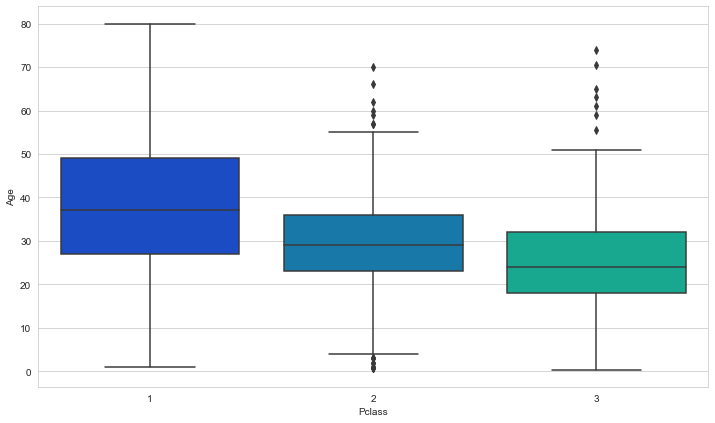

In [31]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')
# There is a relation b/w the passenger class and age, so we use a boxplot to see it, before removing age column/ editing missing values.
# Entering

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [32]:
# A function where we'll give age and Pclass columns and set their age to mean age (if null)
def replace_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass==1:
            return 37
        elif Pclass==2:
            return 29
        else:
            return 24
    else:
        return Age

In [33]:
train['Age'] = train[['Age','Pclass']].apply(replace_age,axis=1)

Now let's check the heatmap again

<AxesSubplot:>

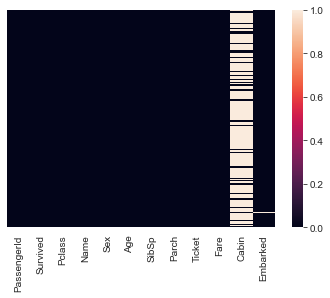

In [34]:
sns.heatmap(train.isnull(),yticklabels=False)
# We've replaced all the Null Age values

Now, let's go ahead and drop the cabin column (bec. it has too many null values and we'll have to apply Feature Engineering {logic} to replace those values, which is not possible) and the row in Embarked that is NaN.

In [35]:
train.drop('Cabin',axis=1,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


<AxesSubplot:>

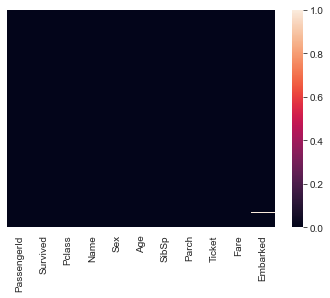

In [36]:
sns.heatmap(train.isnull(),yticklabels=False)

In [37]:
train.dropna(inplace=True)

In [38]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Converting Categorical Features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [40]:
pd.get_dummies(train['Embarked'],drop_first=True).head()
# this is used to turn categorical variables into 
# Convert categorical variable into dummy/indicator variables.
# Each variable is converted in as many 0/1 variables as there are different values.
# Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value.
# When drop_first = True, it created n-1 categories.

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


Here,
- 0 0 = C
- 0 1 = S
- 1 1 = Q

In [41]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [42]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True) # Since these all aren't needed
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


We need to append the sex and embark columns because they're categorical features.


In [43]:
train = pd.concat([train,sex,embark],axis=1)

#### axis = 1 means in column form, axis = 0 means in index/row form

In [44]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Now, our data is ready to use for training our model.

## Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

### Train Test Split

In [45]:
train.drop('Survived',axis=1).head() # Training dataset

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


In [46]:
train['Survived'].head() # O/p dataset

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train,X_test,y_train,y_test = train_test_split(train.drop('Survived',axis=1),train['Survived'],
                                                 test_size=0.30,random_state=101)
# Input array,O/p array,test_size

## Training and Predicting

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/mahakkaurchhabra/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
predictions = logmodel.predict(X_test)

In [52]:
from sklearn.metrics import confusion_matrix

In [54]:
accuracy = confusion_matrix(y_test,predictions)

In [55]:
accuracy

array([[148,  15],
       [ 39,  65]])

In [56]:
from sklearn.metrics import accuracy_score

In [57]:
accuracy = accuracy_score(y_test,predictions)
accuracy

0.797752808988764

In [58]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

## Evaluation
We can check precision,recall,f1-score using classification report!

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.81      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

- Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
- Maybe the Cabin letter could be a feature
- Is there any info you can get from the ticket?